# Эмбеддинги текстов. Векторные модели. Word2Vec

In [1]:
!pip install pymorphy3 gensim scipy russian-tagsets --q

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

План:
- Зачем нам превращать текст в числа?
- Мешок слов
- Tf-Idf
- Word2Vec, GloVe etc.

## Введение

Пусть у нас есть тексты:

1. Мальчик с удовольствием ел горячую пиццу на ужин, запивая её яблочным соком.
2. Ребёнок ужинал пастой с томатным соусом и пил апельсиновый сок за кухонным столом.
3. Подросток поел макароны с сыром вечером и потом съел шоколадку на десерт.
4. Студент усердно готовился к важному экзамену по биологии, просидев над конспектами почти всю ночь.
5. Школьник вечером учил физику, перечитывая учебник и делая записи в тетради перед контрольной.
6. Школьника в вечернее время обучали физике, он перечитывал учебники и вёл записи в тетради до контрольной работы.

Мы хотим выделить в этих текстах две группы похожих между собой (очевидно, это 1-3 и 4-6). Но чтобы дать компьютеру возможность с ним работать, надо перевести текст на понятный для компьютера язык - числа.

Чаще всего каждому слову в тексте (или всему тексту целиком) ставится в соответствие вектор чисел, как-то описывающий это слово. Причем чем лучше такое числовое представление отражает смысл конкретного слова и его отношения с другими словами в языке и текущем контексте, тем лучше.

В идеале мы хотим, чтобы эмбеддинги:
- Были близки (с математической точки зрения) для близких по смыслу слов;
- Были далеки для различающихся по смыслу слов;
- Занимали мало места в памяти;
- Легко и быстро получались.



In [3]:
texts = [
    "Мальчик с удовольствием ел горячую пиццу на ужин, запивая её яблочным соком.",
    "Ребёнок ужинал пастой с томатным соусом и пил апельсиновый сок за кухонным столом.",
    "Подросток поел макароны с сыром вечером и потом съел шоколадку на десерт.",
    "Студент усердно готовился к важному экзамену по биологии, просидев над конспектами почти всю ночь.",
    "Школьник вечером учил физику, перечитывая учебник и делая записи в тетради перед контрольной.",
    "Школьника в вечернее время обучали физике, он перечитывал учебники и делал записи."
]

## Мешок слов

Самый простой способ - представить текст как список входящих в него слов. Чтобы не писать сами слова (тем более, что компьютер их не понимает), дадим им порядковые номера: можно по алфавиту, можно по частоте.

Получим структуру вида:
| | текст 1 | текст 2 | текст 3 |
| -- | -- | -- | -- |
|__слово 1__ | 1 | 0 | 1 |
|__слово 2__ | 1 | 1 | 1 |
|__слово 3__ | 0 | 0 | 0 |
|__слово 4__ | 0 | 1 | 0 |
|__слово 5__ | 0 | 0 | 1 |

Как вы считаете:
- Какое слово больше похоже на стоп-слово?
- Какие слова ключевые для текстов?

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from nltk.corpus import stopwords
from pymorphy3 import MorphAnalyzer
from nltk.tokenize import word_tokenize
from russian_tagsets import converters

import seaborn as sns
from matplotlib import pyplot as plt

stops = stopwords.words('russian')
morph = MorphAnalyzer()
conv = converters.converter('opencorpora-int', 'ud20')

Функция, которая будет считать и рисовать нам близость между текстами

> На всякий случай косинусное расстояние:
$$
\cos \theta = 1 - \frac{\mathbf{a} \cdot \mathbf{b}}{\|\mathbf{a}\|\,\|\mathbf{b}\|} = 1 - \frac{\sum_{i=1}^{n} a_i b_i}{\sqrt{\sum_{i=1}^{n} a_i^2} \, \sqrt{\sum_{i=1}^{n} b_i^2}}
$$

In [5]:
def plot_similarity(vec):
    similarities = cosine_similarity(vec)

    sns.heatmap(similarities)
    plt.xlabel('Номер первого предложения')
    plt.ylabel('Номер второго предложения')

Функция для предобработки текстов

In [6]:
def preprocess_text(text, pos=False):
    text = word_tokenize(text)
    new_text = []
    for word in text:
        if word.isalpha():
            forms = morph.parse(word)[0]
            word = forms.normal_form

            if word not in stops:
                if pos:
                    word = f'{word}_{conv(str(forms.tag)).split()[0]}'
                new_text.append(word)

    return ' '.join(new_text)

In [7]:
# но в ячейках будут частоты, а не 1/0 - так лучше работает
vectorizer = CountVectorizer()
vec = vectorizer.fit_transform(texts)

Посмотрим, какой получился словарь

In [8]:
vectorizer.get_feature_names_out()

array(['апельсиновый', 'биологии', 'важному', 'вечернее', 'вечером',
       'время', 'всю', 'горячую', 'готовился', 'делал', 'делая', 'десерт',
       'ел', 'её', 'за', 'запивая', 'записи', 'конспектами',
       'контрольной', 'кухонным', 'макароны', 'мальчик', 'на', 'над',
       'ночь', 'обучали', 'он', 'пастой', 'перед', 'перечитывал',
       'перечитывая', 'пил', 'пиццу', 'по', 'подросток', 'поел', 'потом',
       'почти', 'просидев', 'ребёнок', 'сок', 'соком', 'соусом', 'столом',
       'студент', 'съел', 'сыром', 'тетради', 'томатным', 'удовольствием',
       'ужин', 'ужинал', 'усердно', 'учебник', 'учебники', 'учил',
       'физике', 'физику', 'школьник', 'школьника', 'шоколадку',
       'экзамену', 'яблочным'], dtype=object)

И какие вектора

In [9]:
vec.toarray()

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Посмотрим, кто с кем похож. Очевидно, что тексты похожи сами на себе, но еще у нас есть явные пары: 0-2, 2-4, 4-5 похожи между собой

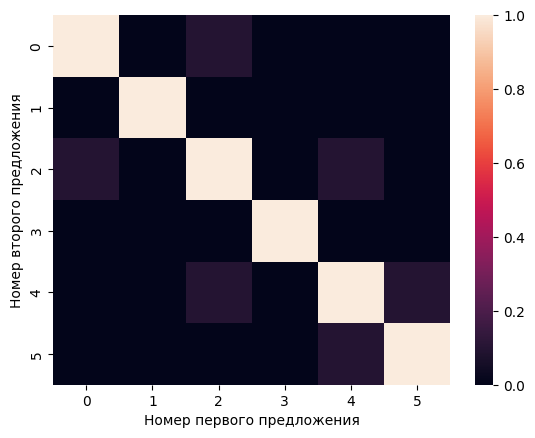

In [10]:
plot_similarity(vec)

А теперь сделаем важную для статистических подходов вещь - предобработаем тексты.

In [11]:
clean_texts = list(map(preprocess_text, texts))
clean_texts

['мальчик удовольствие горячий пицца ужин запивать её яблочный сок',
 'ребёнок ужинать паста томатный соус пить апельсиновый сок кухонный стол',
 'подросток поесть макароны сыр вечером съесть шоколадка десерт',
 'студент усердно готовиться важный экзамен биология просидеть конспект весь ночь',
 'школьник вечером учить физика перечитывать учебник делать запись тетрадь контрольный',
 'школьник вечерний время обучать физика перечитывать учебник делать запись']

In [12]:
vectorizer = CountVectorizer()
vec = vectorizer.fit_transform(clean_texts)
vectorizer.get_feature_names_out()

array(['апельсиновый', 'биология', 'важный', 'весь', 'вечерний',
       'вечером', 'время', 'горячий', 'готовиться', 'делать', 'десерт',
       'её', 'запивать', 'запись', 'конспект', 'контрольный', 'кухонный',
       'макароны', 'мальчик', 'ночь', 'обучать', 'паста', 'перечитывать',
       'пить', 'пицца', 'подросток', 'поесть', 'просидеть', 'ребёнок',
       'сок', 'соус', 'стол', 'студент', 'съесть', 'сыр', 'тетрадь',
       'томатный', 'удовольствие', 'ужин', 'ужинать', 'усердно',
       'учебник', 'учить', 'физика', 'школьник', 'шоколадка', 'экзамен',
       'яблочный'], dtype=object)

Увидим, что последние два текста очень похожи: они буквально состоят почти из одних и тех же слов, просто в разных формах

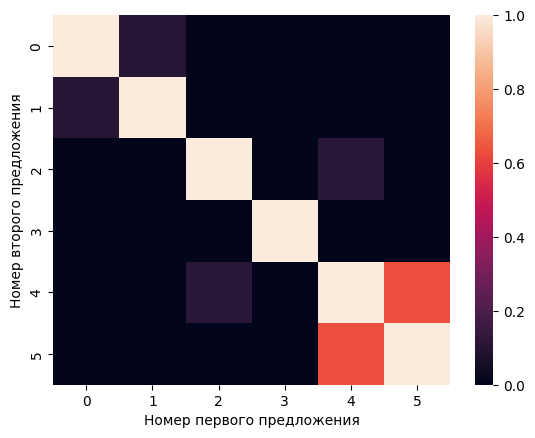

In [13]:
plot_similarity(vec)

## Tf-Idf

Проблема мешка слов заключается в том, что он не учитывает несколько вещей:
- Бывают более и менее редкие слов, бывают тексты разной длины. Абсолютные значения частот этого не учитывают;
- Есть более или менее специфичные слова.

Зато все это учитывает TF-IDF:

$$\text{tf-idf}(t, d, D) = \text{tf}(t, d) \times \text{idf}(t, D)$$

где

- $\text{tf}(t, d) = \frac{f_{t,d}}{\sum_{t' \in d} f_{t',d}}$ — частота термина \(t\) в документе \(d\);
- $\text{idf}(t, D) = \log \frac{N}{1 + |\{d \in D : t \in d\}|}$ — обратная документная частота.


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
vectorizer = TfidfVectorizer()
vec = vectorizer.fit_transform(texts)
vec.toarray()[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.30610363, 0.        , 0.        ,
       0.        , 0.        , 0.30610363, 0.30610363, 0.        ,
       0.30610363, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.30610363, 0.25100935, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.30610363, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.30610363, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.30610363,
       0.30610363, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.30610363])

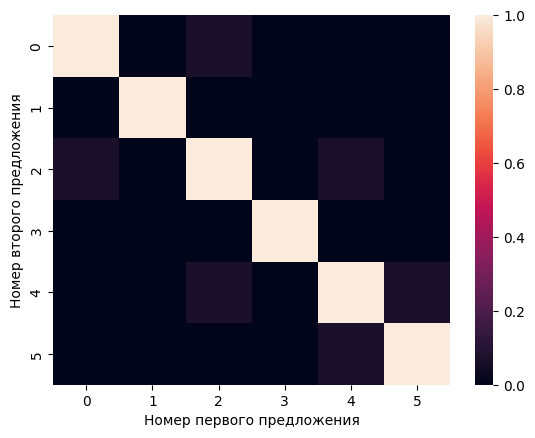

In [16]:
plot_similarity(vec)

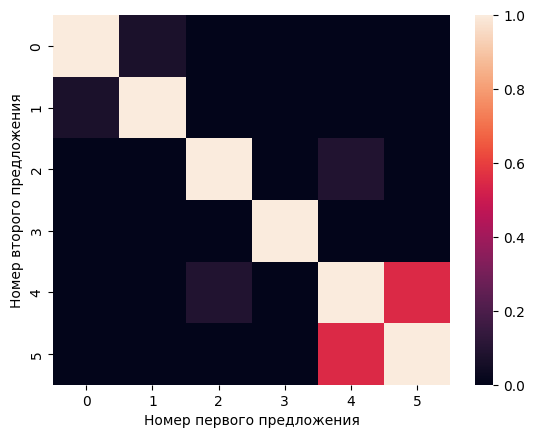

In [17]:
vectorizer = TfidfVectorizer()
vec = vectorizer.fit_transform(clean_texts)
plot_similarity(vec)

## Word2Vec & Co

Отдельно существуют методы векторизации, основанные на дистрибутивной семантике. Ее идея заключается в том, что смысл слова определяется его контекстом. Таким образом, похожие слова - это слова, встречающиеся в похожих контекстах.

На подобных принципах основана целая группа моделей:
- __GloVe__: считается матрица совместной встречаемости слов, после чего с помощью алгоритомв уменьшения размерности она преобразуется так, чтобы вектора были опредленной длины;
- __Word2Vec__: это уже нейросеть, при ее обучении на основе корпуса постепенно подбираются коэффициенты (значения в векторах) для каждого слова так, чтобы с помощью них можно было наилучшим образом предсказывать слова по контексту;
- __FastText__: то же, что и word2vec, но на буквенныз нграммах, что помогает работать с незнакомыми словами;
- __AdaGram__: умеет разделять несколько значений у одного слова на основе Байесовсого подхода.

Мы остановимся подробнее на Word2Vec, как на наиболее распространенной и единственной (еще может быть FastText) свободно доступной до сих пор. Этот инструмент был разработан группой исследователей Google в 2013 году, руководителем проекта был Томаш Миколов.

Основные работы про Word2Vec:
- [Efficient Estimation of Word Representations inVector Space](https://arxiv.org/abs/1301.3781)
- [Distributed Representations of Words and Phrases and their Compositionality](https://arxiv.org/abs/1310.4546)

Так как такие модели обычно обучаются на большом объеме текстов, обучать свою долго, дорого и нецелесообразно, поэтому мы сначала будем использовать готовую, но потом все-таки посмотрим, как обучить свою. В целом, для русского языка готовые модели есть на сайте __rusvectores.org__ (иногда сайту бывает нехорошо и он не работает).

__Что такое Word2Vec?__

Модель представляет собой словарь вида "слово: вектор", чаще всего вектор содержит 300 значений (число в какой-то момент было подобрано эмпирически и закрепилось). Причем вектора обладают интересной парой свойств:
- Каждая конкретная координата скорее не имеет понятной человеку интерпретации;
- Вектора в целом при этом позволяют выделять закономерности различной сложности:

<img src="https://towardsdatascience.com/wp-content/uploads/2021/03/15F4TXdFYwqi-BWTToQPIfg.jpeg">

Ещё про механику с картинками [тут](https://habr.com/ru/post/446530/)

__Зачем это нужно?__

+ используется для решения семантических задач
+ подаётся на вход нейронным сетям
+ раньше использовался в Siri, Google Assistant, Alexa, Google Translate, но современным моделям уже однозначно проигрывает...

*Давайте подумаем, для описания каких семантических классов слов дистрибутивная информация особенно важна?*

Несколько интересных статей по дистрибутивной семантике:

* [Turney and Pantel 2010](https://jair.org/index.php/jair/article/view/10640)
* [Lenci 2018](https://www.annualreviews.org/doi/abs/10.1146/annurev-linguistics-030514-125254?journalCode=linguistics)
* [Smith 2019](https://arxiv.org/pdf/1902.06006.pdf)
* [Pennington et al. 2014](https://www.aclweb.org/anthology/D14-1162/)
* [Faruqui et al. 2015](https://www.aclweb.org/anthology/N15-1184/)

__Gensim__

Использовать предобученную модель эмбеддингов или обучить свою можно с помощью библиотеки `gensim`. Вот ее [документация](https://radimrehurek.com/gensim/models/word2vec.html). Вообще-то `gensim` — библиотека для тематического моделирования текстов, но один из компонентов в ней — реализация на python алгоритмов из библиотеки word2vec (которая в оригинале была написана на C++).

Если gensim у вас не стоит, то ставим: `!pip install gensim`.

In [18]:
from gensim.models import KeyedVectors
import numpy as np

In [19]:
# или можно напрямую по ссылке скачать, если не хочется через wget
!wget https://rusvectores.org/static/models/rusvectores4/RNC/ruscorpora_upos_skipgram_300_5_2018.vec.gz

--2025-10-23 14:55:03--  https://rusvectores.org/static/models/rusvectores4/RNC/ruscorpora_upos_skipgram_300_5_2018.vec.gz
Resolving rusvectores.org (rusvectores.org)... 129.240.189.200, 2001:700:112::200
Connecting to rusvectores.org (rusvectores.org)|129.240.189.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 199864398 (191M) [application/x-gzip]
Saving to: ‘ruscorpora_upos_skipgram_300_5_2018.vec.gz.2’

ruscorpora_upos_ski 100%[===================>] 190.61M  12.2MB/s    in 16s     

2025-10-23 14:55:20 (11.6 MB/s) - ‘ruscorpora_upos_skipgram_300_5_2018.vec.gz.2’ saved [199864398/199864398]



In [20]:
model = KeyedVectors.load_word2vec_format('ruscorpora_upos_skipgram_300_5_2018.vec.gz')

Многие модели word2vec требуют частей речи для применения, поэтому слова надо подавать в формате "слово_ЧАСТЬ РЕЧИ"

In [21]:
model['кошка_NOUN'][:10]

array([ 0.053885,  0.076832, -0.020836,  0.050466, -0.018344,  0.024962,
        0.022273, -0.069766, -0.067729,  0.026725], dtype=float32)

Посмотрим на ближайшие

In [22]:
model.most_similar('кошка_NOUN')

[('кот_NOUN', 0.7805721759796143),
 ('собака_NOUN', 0.7084056735038757),
 ('котенок_NOUN', 0.6833623647689819),
 ('мяукать_VERB', 0.661374568939209),
 ('мяукать_NOUN', 0.6479178071022034),
 ('клеточка_PROPN', 0.642410397529602),
 ('тобик_PROPN', 0.6401645541191101),
 ('крыса_NOUN', 0.635063648223877),
 ('котенка_NOUN', 0.629923939704895),
 ('окотиться_VERB', 0.6232213973999023)]

Функция для векторизации текста

In [23]:
def vectorize_text(text):
    text = preprocess_text(text, pos=True).split()
    vecs = []
    for word in text:
        if word in model:
            vecs.append(model[word])
    return np.vstack(vecs).mean(axis=0)

In [24]:
vecs = np.vstack(list(map(vectorize_text, texts)))
vecs

array([[-0.07098313,  0.00865387,  0.02144413, ..., -0.02943538,
         0.0330795 ,  0.03685575],
       [-0.04000477, -0.00743911,  0.01201422, ..., -0.02488989,
         0.04465611,  0.02580667],
       [-0.06250743,  0.02175429,  0.00584186, ...,  0.00108514,
         0.04665972,  0.01459186],
       [-0.029877  , -0.04032711, -0.00018533, ..., -0.06681278,
         0.02328756,  0.00798933],
       [-0.026793  , -0.04201111,  0.01011044, ..., -0.02136367,
         0.00223367,  0.008629  ],
       [-0.03181133, -0.047093  ,  0.01709333, ..., -0.02349167,
         0.00280967,  0.01149544]], dtype=float32)

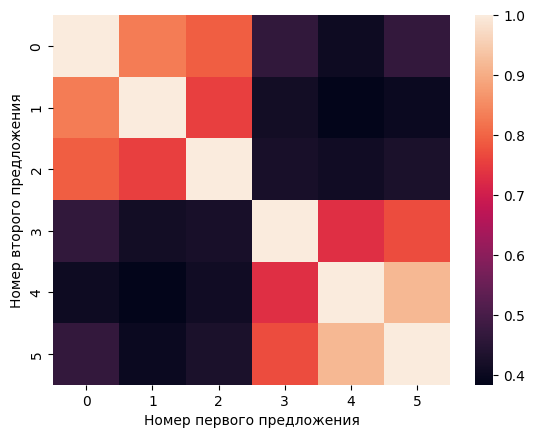

In [25]:
plot_similarity(vecs)

К сожалению, у word2vec есть несколько минусов. Он
- Не учитывает порядок слов и синтаксические зависимости;
- Не умеет работать с незнакомыми словами (это словарь: нет ключей - нет значений);
- Путает синонимы и антонимы;

In [26]:
model.most_similar('зло_NOUN')

[('добро_NOUN', 0.7334719896316528),
 ('зломя_NOUN', 0.7035925984382629),
 ('зло_VERB', 0.6938475370407104),
 ('насилием_NOUN', 0.6638540029525757),
 ('злу_NOUN', 0.6549335718154907),
 ('злой_NOUN', 0.6526554822921753),
 ('зло_ADV', 0.6483572125434875),
 ('противьтесь_VERB', 0.6258615851402283),
 ('злом_NOUN', 0.620617151260376),
 ('насилие_PROPN', 0.5829303860664368)]

- Не различает омонимы (и чаще всего предпочитает одно из значений);

In [27]:
model.most_similar('замок_NOUN')

[('замокнуть_NOUN', 0.7464022636413574),
 ('замок_ADJ', 0.6631044149398804),
 ('замок_PROPN', 0.6569739580154419),
 ('мондидье_PROPN', 0.6153575778007507),
 ('запираемый_VERB', 0.5956321358680725),
 ('засово_NOUN', 0.5905193090438843),
 ('венсенский_ADJ', 0.588593602180481),
 ('сейфовый_ADJ', 0.5803343057632446),
 ('защелкгиваться_VERB', 0.579129695892334),
 ('отопревать_VERB', 0.575293242931366)]

In [28]:
model.most_similar('лук_NOUN')

[('репчатый_ADJ', 0.7018033862113953),
 ('репчатый_VERB', 0.6678007245063782),
 ('нашинковать_VERB', 0.6440962553024292),
 ('сельдерей_NOUN', 0.6314660906791687),
 ('морковь_NOUN', 0.628654420375824),
 ('лук-порей_ADV', 0.6253951191902161),
 ('чеснок_NOUN', 0.6183842420578003),
 ('помидор_NOUN', 0.6150241494178772),
 ('каперс_NOUN', 0.6140490770339966),
 ('спассеровать_VERB', 0.6125704050064087)]

### Свой Word2Vec

#### (если будет время) Как он обучается: CBOW и SkipGram

Для обучения word2vec используется два противоположных подхода. У готовых моделей чаще всего указывается, какой именно подход был выбран. С точки зрения структуры этот выбор влияет на то, какие данные нужны на вход и что именно будет предсказывать голова классификации.

<img src="https://sspark.genspark.ai/cfimages?u1=nXKWQ3UFEwWMX9oL5OTiR1CdzuV5WIlm1v%2BpVS1JvMOnwhi5xuoieffilAaP80%2FKFGoCY4TaWIWXgLp6xAXzSjvln8P6H482%2FErY07zDa1s6MKiG2eG5&u2=WAaxhmdojPZnoS9b&width=1024" width=700>

##### CBOW

Здесь идея в том, чтобы по контексту восстановить пропущенное слово. Для этого делаем следующее:
1. Выбираем параметр n - размер окна;
2. Делим текст на окна так, что от каждого слова (или с каким-то шагом) пытаемся взять в право и влево по n соседних слов;

> Предложение: Милый котик играет с клубком пряжи

| Центральное слово | Контекстные слова     |
|-------------------|-----------------------|
| Милый             | котик                 |
| котик             | Милый, играет         |
| играет            | котик, с              |
| с                 | играет, клубком       |
| клубком           | с, пряжи              |
| пряжи             | клубком               |

3. Получаем эмбеддинги для каждого слова в контексте, считаем их сумму/среднее/конкатенируем (бывает по-разному);
4. Пытаемся предсказать центральное слово с помощью головы классификации.


##### SkipGram

Восстанавливаем контекст по ценитральному слову. Для этого делаем следующее:
1. Выбираем параметр n - размер окна;
2. Делим текст на окна так, что от каждого слова (или с каким-то шагом) пытаемся взять в право и влево по n соседних слов; берем пары вида центральное слово - одно слово из контекста;

> Предложение: Милый котик играет с клубком пряжи

| Центральное слово | Контекстные слова     |
|-------------------|-----------------------|
| Милый             | котик                 |
| котик             | Милый, играет         |
| играет            | котик, с              |
| с                 | играет, клубком       |
| клубком           | с, пряжи              |
| пряжи             | клубком               |

Данные для обучения (можно убирать дубликаты внутри предложения, можно не убирать):
| Центральное слово | Контекстное слово     |
|-------------------|-----------------------|
| Милый             | котик                 |
| котик             | Милый       |
| котик             | играет         |
| играет            | котик              |
| играет            | с              |
| с                 | играет      |
| с                 | клубком       |
| клубком           | с              |
| клубком           | пряжи              |
| пряжи             | клубком               |

3. Получаем эмбеддинг для центрального слова;
4. Пытаемся предсказать контекстное слово с помощью головы классификации.


##### Negative Sampling

Описанные выше подходы неприятны тем, что проследний этап, предсказание слова из словаря, очень дорогой вычислительно: там чисто для классификации нужна матрица, совпадающая по размерности с матрицией эмбеддингов. Только матрица эмбеддингов - это необходимая нам часть модели, а голова классификации нужна только для обучения!

Поэтому был придуман подход, основанный на бинарной классификации. Как он работает:
1. Выбираем параметр n - размер окна;
2. Делим текст на окна так, что от каждого слова (или с каким-то шагом) пытаемся взять в право и влево по n соседних слов; берем все пары слов, оказавшихся в этом окне;

> Предложение: Милый котик играет с клубком пряжи

| Центральное слово | Контекстное слово     |
|-------------------|-----------------------|
| Милый             | котик                 |
| котик             | Милый       |
| котик             | играет         |
| играет            | котик              |
| играет            | с              |
| с                 | играет      |
| с                 | клубком       |
| клубком           | с              |
| клубком           | пряжи              |
| пряжи             | клубком               |

3. Получаем эмбеддинг для обоих слов в паре;
4. Предсказываем по паре 1/0 - являются ли эти слова контекстом друг для друга.

Такой подход решает вопрос с неэффективностью, потому что на выходе голова на 2 класса, а не на 100 тысяч классов, однако создает новую проблему: при выбранном подходе к генерации данных мы создаем только примеры из класса 1 (соседствующие в контексте).

Чтобы решить этот вопрос, мы используем Negative Sampling: добавляем в данные негативные примеры, которые создаем из случайных пар слов в словаре.

Все вместе это называется __SkipGram with Negative Sampling__ - и сейчас это один из основных подходов к обучению word2vec.

#### Обучаем Word2Vec через gensim

NB! Обратите внимание, что тренировка модели не включает препроцессинг! Это значит, что избавляться от пунктуации, приводить слова к нижнему регистру, лемматизировать их, проставлять частеречные теги придется до тренировки модели (если, конечно, это необходимо для вашей задачи). Т.е. в каком виде слова будут в исходном тексте, в таком они будут и в модели.

Поскольку иногда тренировка модели занимает много времени, то можно ещё вести лог событий, чтобы понимать, что на каком этапе происходит.

In [29]:
import gensim

import logging
import warnings

warnings.filterwarnings('ignore')

In [30]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

На вход модели даем текстовый файл, каждое предложение на отдельной строчке. Вот игрушечный пример с текстом «Бедной Лизы». Он заранее очищен от пунктуации, приведен к нижнему регистру и лемматизирован.

In [31]:
!wget https://raw.githubusercontent.com/hse-ling-python/seminars/refs/heads/master/vector_models/liza_lem.txt

--2025-10-23 14:57:13--  https://raw.githubusercontent.com/hse-ling-python/seminars/refs/heads/master/vector_models/liza_lem.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42747 (42K) [text/plain]
Saving to: ‘liza_lem.txt.3’

liza_lem.txt.3      100%[===================>]  41.75K  --.-KB/s    in 0.005s  

2025-10-23 14:57:13 (7.67 MB/s) - ‘liza_lem.txt.3’ saved [42747/42747]



In [32]:
f = 'liza_lem.txt'
data = gensim.models.word2vec.LineSentence(f)

Обучим модель. Основные параметры:
- данные: должны быть итерируемым объектом
- size — размер вектора,
- window — размер окна наблюдения,
- min_count — мин. частотность слова в корпусе,
- sg — используемый алгоритм обучения (0 — CBOW, 1 — Skip-gram),
- sample — порог для downsampling'a высокочастотных слов,
- workers — количество потоков,
- alpha — learning rate,
- epochs — количество итераций,
- max_vocab_size — позволяет выставить ограничение по памяти при создании словаря (т.е. если ограничение привышается, то низкочастотные слова будут выбрасываться). Для сравнения: 10 млн слов = 1Гб RAM.

In [33]:
%time model = gensim.models.Word2Vec(data, vector_size=300, window=5, min_count=2, sg=1, epochs=10)

CPU times: user 174 ms, sys: 12.8 ms, total: 187 ms
Wall time: 194 ms


Можно нормализовать вектора, тогда модель будет занимать меньше RAM. Однако после этого её нельзя дотренировывать. Здесь используется L2-нормализация: вектора нормализуются так, что если сложить квадраты всех элементов вектора, в сумме получится 1.

В более поздних версиях это перестает быть обязательным.

In [34]:
model.init_sims(replace=True)

Можем сохранить нашу модель в файл, причем оставить только эмбеддинги: так она будет занимать меньше места и быстрее читаться

In [35]:
model_path = "liza_model.bin"
model.wv.save_word2vec_format(model_path, binary=True)

Прочитаем, проверим, что все окей

In [36]:
model = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [37]:
np.linalg.norm(model['лиза'])

np.float32(0.99999994)

In [38]:
model.most_similar('лиза')

[('свой', 0.9989644289016724),
 ('который', 0.9989140629768372),
 ('мой', 0.9985422492027283),
 ('сей', 0.9984121918678284),
 ('мочь', 0.9983697533607483),
 ('хотеть', 0.9983149766921997),
 ('слеза', 0.9982987642288208),
 ('смотреть', 0.9982856512069702),
 ('рука', 0.9982788562774658),
 ('любовь', 0.9982542395591736)]

In [39]:
print(len(model.key_to_index))

478


In [40]:
print(sorted([w for w in model.key_to_index])[100:200])

['доживать', 'долго', 'должный', 'дом', 'домой', 'дочь', 'древний', 'друг', 'другой', 'дуб', 'думать', 'душа', 'едва', 'ехать', 'жалобный', 'желание', 'желать', 'жениться', 'жених', 'женщина', 'жестокий', 'живой', 'жизнь', 'жить', 'забава', 'заблуждение', 'забывать', 'завтра', 'задумчивость', 'закраснеться', 'закричать', 'заря', 'здешний', 'здравствовать', 'зеленый', 'земля', 'златой', 'знать', 'ибо', 'играть', 'идти', 'имя', 'искать', 'исполняться', 'испугаться', 'история', 'исчезать', 'кабинет', 'казаться', 'какой', 'капля', 'карета', 'карман', 'картина', 'катиться', 'келья', 'клятва', 'колено', 'копейка', 'который', 'красота', 'крест', 'крестьянин', 'крестьянка', 'кровь', 'кроме', 'кто', 'купить', 'ландыш', 'ласка', 'ласковый', 'левый', 'лес', 'лететь', 'летний', 'лето', 'лиза', 'лизин', 'лизина', 'лицо', 'лишний', 'лодка', 'ложиться', 'луг', 'луч', 'любезный', 'любить', 'любовь', 'лютый', 'матушка', 'мать', 'место', 'месяц', 'мечта', 'милый', 'мимо', 'минута', 'многочисленный', 'мо

Обратим внимание, что наша модель менее хороошая, чем та, которую мы взяли с сайта. По большей части, это из-за маленького объема данных, однако есть и другие параметры, которые можно менять:

- препроцессинг: лемматизировать или нет, например, вдруг мы хотим посмотреть на морфологические пропорции? тогда лемматизировать не нужно
- размер корпуса: чем больше, тем лучше, но! не для семантических задач, для них важнее качество
- размер словаря
- negative samples
- количество итераций
- длина вектора: 100-300 (судя по всему, >300 не сильно улучшает результаты)
- длина окна: для синтаксических задач, примерно 4, для семантических задач, большое окно, 8, 10.

Хорошая статья про сравнение моделей с варьированием параметров: https://www.aclweb.org/anthology/D14-1162.pdf